In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


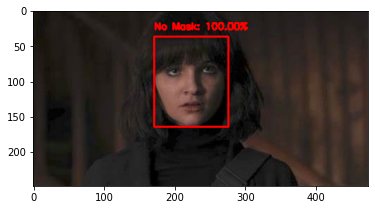

In [5]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["face_detector", "res10_300x300_ssd_iter_140000.caffemodel"])

net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model("model_InceptionV3")

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('./sample/pic3.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
  confidence = detections[0, 0, i, 2]
  if confidence > 0.5:
    box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
    (startX, startY, endX, endY) = box.astype("int")

    (startX, startY) = (max(0, startX), max(0, startY))
    (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
    face = image[startY:endY, startX:endX]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)

    (mask, withoutMask) = model.predict(face)[0]

    label = "Mask" if mask > withoutMask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    cv2.putText(image, 
                label, 
                (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)